In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.3 MB/s eta 0:00:00


In [2]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/JEOPARDY_CSV.csv')

In [6]:
df = df[[' Round',' Question']]
df[' Round'].value_counts()

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name:  Round, dtype: int64

In [7]:
df_j = df[df[' Round'] == "Jeopardy!"].sample(frac=3631/107384,random_state=200)
df_dj = df[df[' Round'] == "Double Jeopardy!"].sample(frac=3631/105912,random_state=200)
df_fj = df[df[' Round'] == "Final Jeopardy!"]
df_t = df[df[' Round'] == "Tiebreaker"]
df = pd.concat( (df_j, df_dj, df_fj, df_t), ignore_index = True)
df[' Round'].value_counts()

Jeopardy!           3631
Double Jeopardy!    3631
Final Jeopardy!     3631
Tiebreaker             3
Name:  Round, dtype: int64

In [8]:
df = df.rename(columns={' Question': 'TITLE',' Round': 'CATEGORY'})
df.head()

,CATEGORY,TITLE
0,Jeopardy!,It's the Hawaiian title of the following
1,Jeopardy!,In the North Atlantic: CLND
2,Jeopardy!,He led the young Seminoles who opposed the 183...
3,Jeopardy!,Former Husker head coach & now Congressman Tom...
4,Jeopardy!,Mother's Day is in May; Father's Day is in Jun...


In [9]:
# most_common_cat_count = df['CATEGORY'].value_counts().nlargest(4)
# most_common_cat_count

In [10]:
# most_common_cat = most_common_cat_count.index.tolist()
# df = df[df['CATEGORY'].isin(most_common_cat)]
#encoded_labels = {'BEFORE & AFTER':0, 'SCIENCE': 1, 'LITERATURE': 2, 'AMERICAN HISTORY': 3, 'POTPOURRI': 4}
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))
df['ENCODE_CAT'].unique()

array([0, 1, 2, 3])

In [11]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 3
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [12]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [13]:
# Creating the dataset and dataloader for the neural network
df = df.sample(frac=0.8,random_state=200)
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (8717, 3)
TRAIN Dataset: (6974, 3)
TEST Dataset: (1743, 3)


In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [15]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [16]:
model = DistillBERTClass()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [17]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [18]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [19]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [20]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.3825650215148926
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 0: 40.92342988242042
Training Loss Epoch: 1.0711394226810802
Training Accuracy Epoch: 40.92342988242042
Training Loss per 5000 steps: 1.078014850616455
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 1: 48.83854316030972
Training Loss Epoch: 0.9698887897330687
Training Accuracy Epoch: 48.83854316030972
Training Loss per 5000 steps: 0.8701893091201782
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 2: 57.77172354459421
Training Loss Epoch: 0.8321811717875097
Training Accuracy Epoch: 57.77172354459421


In [21]:
def valid(model, testing_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [22]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.178696632385254
Validation Accuracy per 100 steps: 66.66666666666667
Validation Loss Epoch: 1.0113967430365887
Validation Accuracy Epoch: 49.16810097532989
Accuracy on test data = 49.17%


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


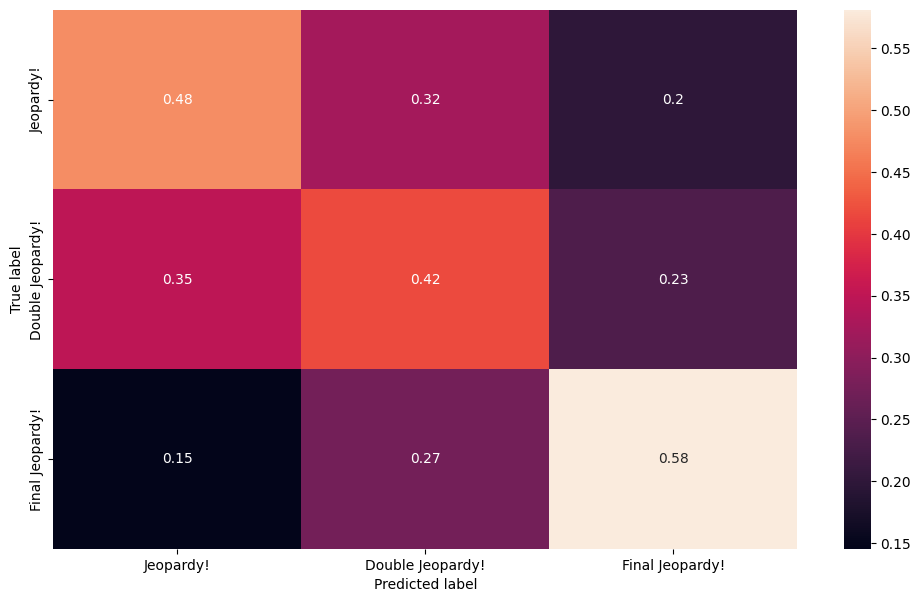

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for batch in testing_loader:
        inputs = batch['ids'].to(device, dtype = torch.long)
        labels = batch['targets'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        output = model(inputs, mask) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# only three rounds included because Tiebreaker doesn't occur in the test dataset
classes = ('Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('gdrive/MyDrive/Colab Notebooks/heatmap_round_bert_even.png')